# Borders, Obstacles & Buffering

**OptiWindNet** models site bounds with an exterior **border** (build area) and interior **obstacles** (exclusions), and keeps electrical network design compliant with the bounds. This notebook walks from initialization and optimization under constraints, through cleaning and buffering the geometry, to validating turbine/substation placement. We will explore following features (methods):

* **Optimize under bounds**: `.optimize()`: optimize electrical network while enforcing border/obstacle constraints.
* **Merge & clean boundary**: `.merge_obstacles_into_border()`: resolve intersections/touching constriants, absorb irrelevant obstacles, and simplify the exterior boundary.
* **Buffer geometry**: `.add_buffer(buffer_dist=...)`: expand the border and shrink obstacles to add safety margins; might smooth concavities or remove obstacles depending on `buffer_dist`.
* **Compare originals vs buffered**: `.plot_original_vs_buffered()`: overlay plot of border/obstacles before and after buffering to inspect how buffering changed shapes.
* **Validate placement**: `.is_layout_within_bounds()`: confirm turbines/substations lie inside the border and outside obstacles.

Import required packages

In [1]:
from optiwindnet.api import WindFarmNetwork
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## Borders and obstacles

### 1. Initialize
Create a `WindFarmNetwork` instances from an `osm.pbf´ file and optimize it.

In [3]:
wfn1 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)


Plot the location geometry and the optimized network to confirm that the borders and obstacles are properly initailized and considered for optimization.

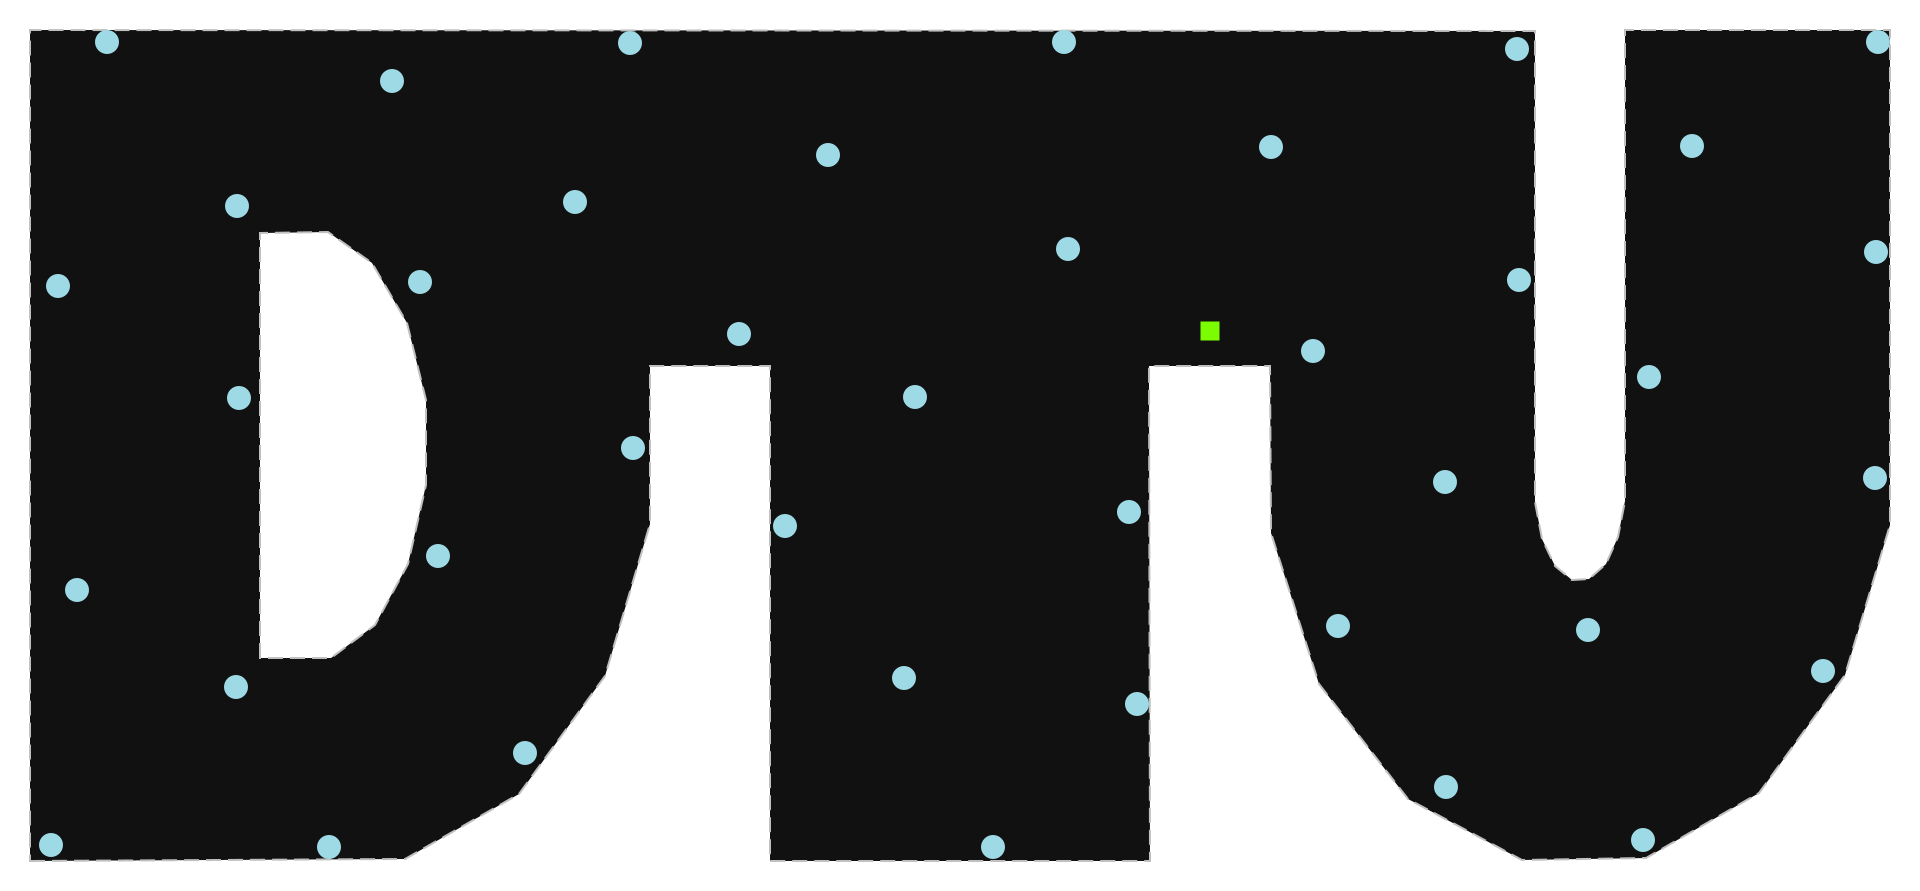

In [4]:
wfn1

In [5]:
wfn1.L.graph['T']

40

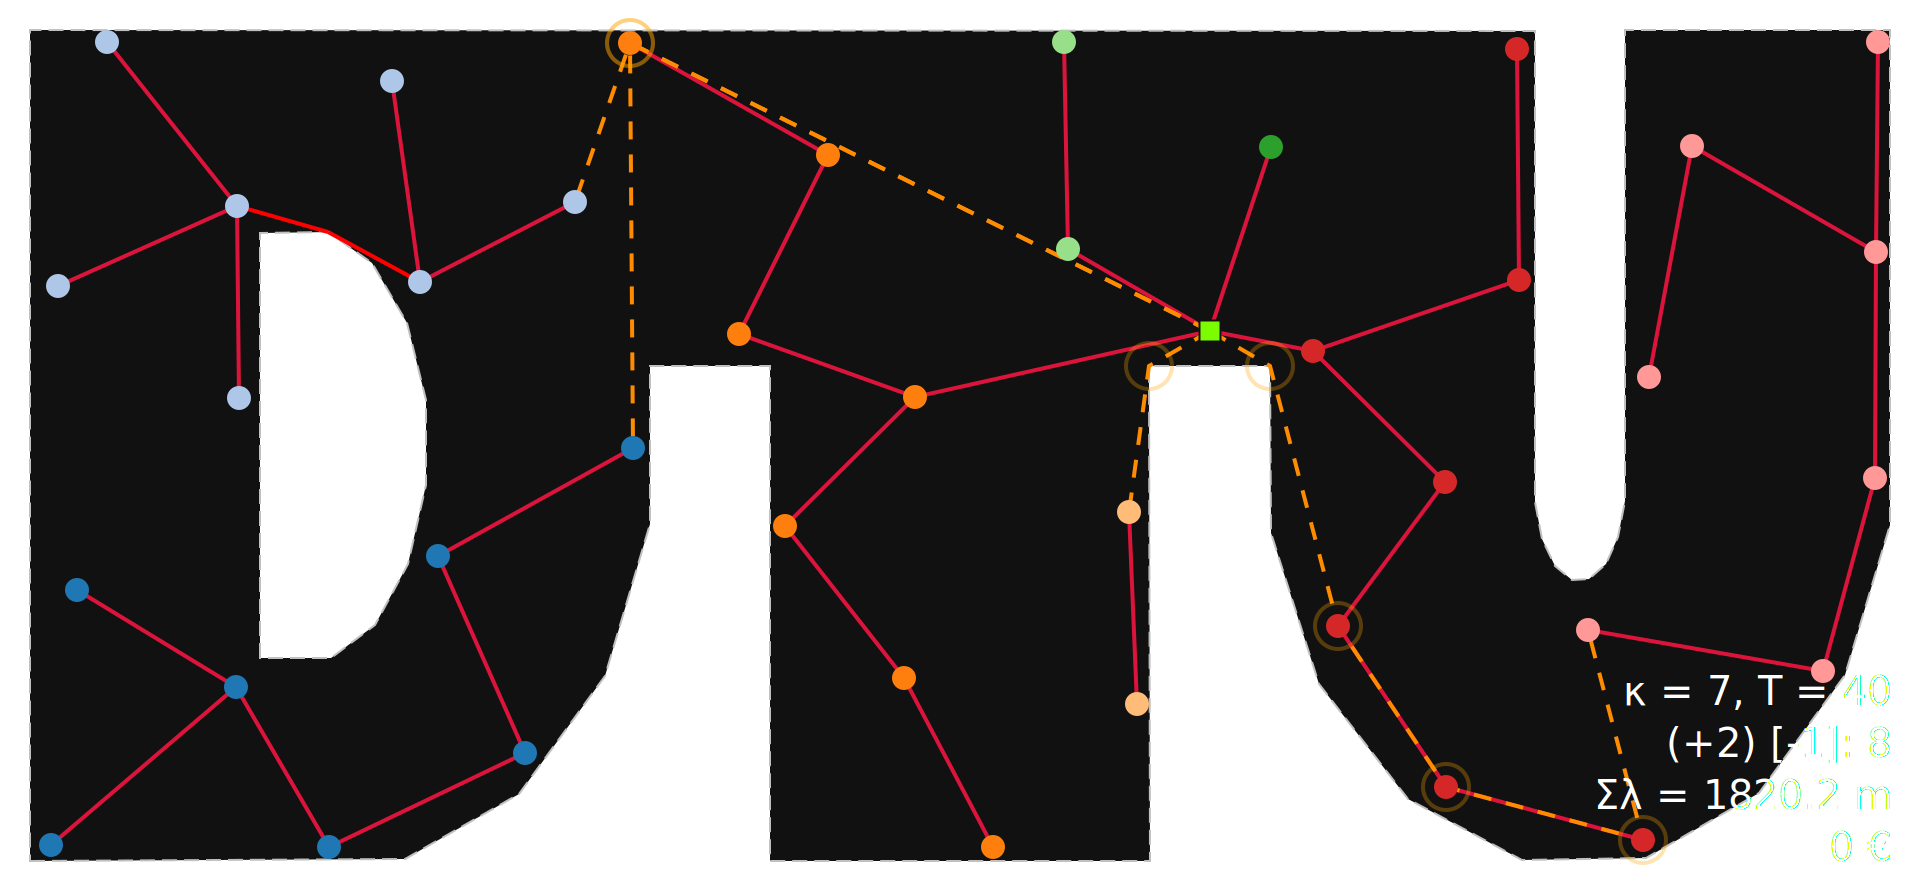

In [6]:
res_optimize = wfn1.optimize()
wfn1

> Note: OptiWindNet works properly without borders/obstacles also.

### 2. Obstacles intersecting with the exterior borders

Let's create an instance of WindFarmNetwork directly via coordinates to have full control over border/obstacle definition.

In [7]:
turbinesC = np.array([
       [ 316976, 6175410],
       [ 316998, 6175380],
       [ 316965, 6175368],
       [ 316997, 6175347],
       [ 316967 , 6175314],
       [ 317009 , 6175267],
       [ 317044, 6175282],
       [ 316994 , 6175296],
       [ 317065, 6175335],
       [ 317030, 6175318],
       [ 317029 , 6175366],
       [ 317026, 6175401],
       [ 317057, 6175379],
       [ 317085, 6175354],
       [ 317068, 6175406],
       [ 317144, 6175403],
       [ 317115, 6175342],
       [ 317091, 6175320],
       [ 317240, 6175259],
       [ 317111 , 6175293],
       [ 317126, 6175262],
       [ 317152, 6175320],
       [ 317102, 6175385],
       [ 317179, 6175383],
       [ 317143, 6175367],
       [ 317223, 6175399],
       [ 317222, 6175358],
       [ 317185, 6175347],
       [ 317208, 6175323],
       [ 317188, 6175299],
       [ 317205, 6175270],
       [ 317231, 6175296],
       [ 317272, 6175287],
       [ 317244, 6175340],
       [ 317283, 6175321],
       [ 317285, 6175360],
       [ 316960, 6175270],
       [ 317253, 6175380],
       [ 317287, 6175397],
       [ 317152, 6175286],
       ])

borderC = np.array([
       [316956, 6175267],
       [317022, 6175265],
       [317043, 6175275],
       [317059 , 6175295],
       [317068, 6175322],
       [317069, 6175349],
       [317090, 6175348],
       [317086, 6175262],
       [317153, 6175259],
       [317157, 6175346],
       [317178 , 6175345],
       [317177, 6175316],
       [317184, 6175289],
       [317199, 6175268],
       [317218, 6175256],
       [317240, 6175256],
       [317260, 6175266],
       [317276, 6175286],
       [317285, 6175312],
       [317289, 6175399],
       [317242, 6175401],
       [317239, 6175319],
       [317238, 6175312],
       [317235, 6175308],
       [317232, 6175305],
       [317229, 6175305],
       [317226, 6175308],
       [317224, 6175313],
       [317223, 6175319],
       [317227, 6175402],
       [316963, 6175413],
       ])

obstaclesC_ = [
    np.array([
       [316998, 6175301],
       [317001 , 6175376],
       [317013, 6175375],
       [317021, 6175369],
       [317026, 6175359],
       [317029, 6175345],
       [317029, 6175330],
       [317025, 6175316],
       [317019, 6175306],
       [317011, 6175301],
       ]),
    np.array([
       [316920, 6175300],
       [316920, 6175400],
       [316950, 6175400],
       [316950, 6175300],
       ]),
    np.array([
       [317100, 6175450],
       [317100, 6175400],
       [317080, 6175400],
       [317080, 6175450],
       ]),
       ]

substationsC = np.array([
       [317167 , 6175351]])

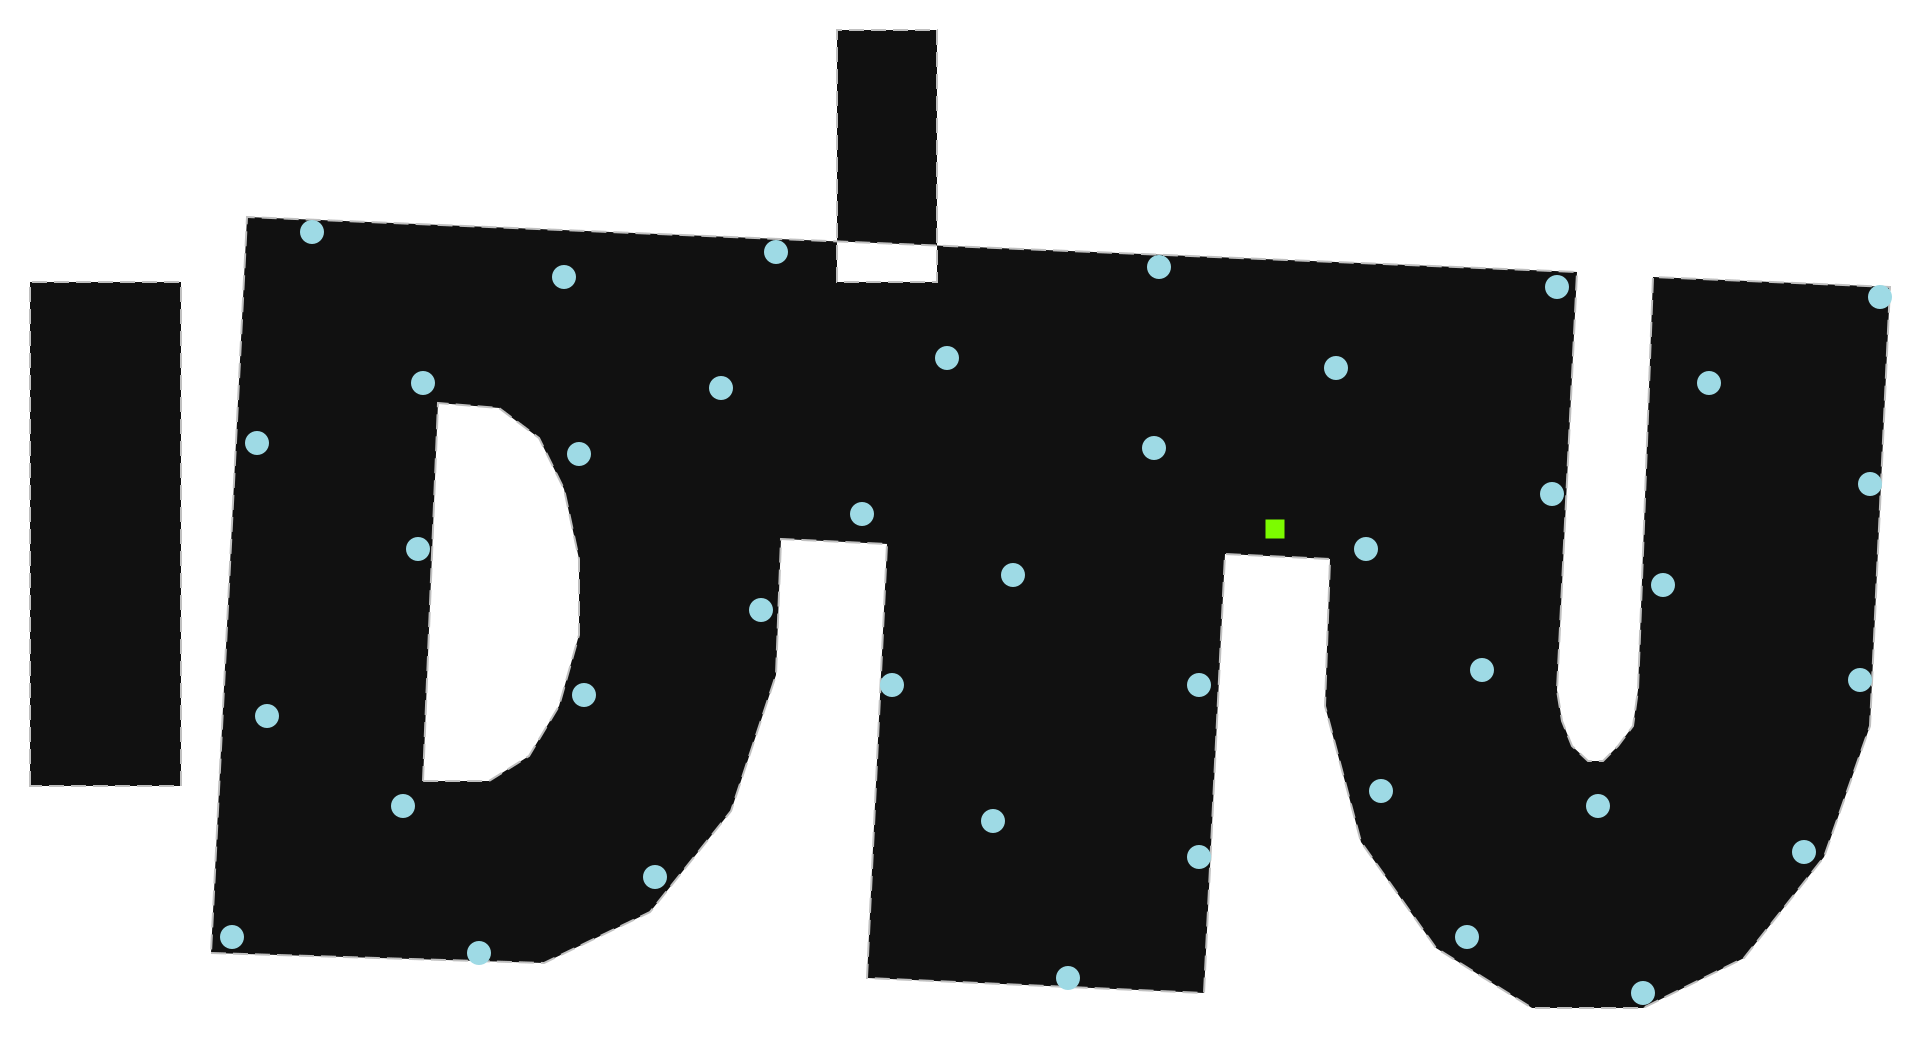

In [8]:
wfn2 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, borderC=borderC, obstacleC_=obstaclesC_, cables=7)
wfn2

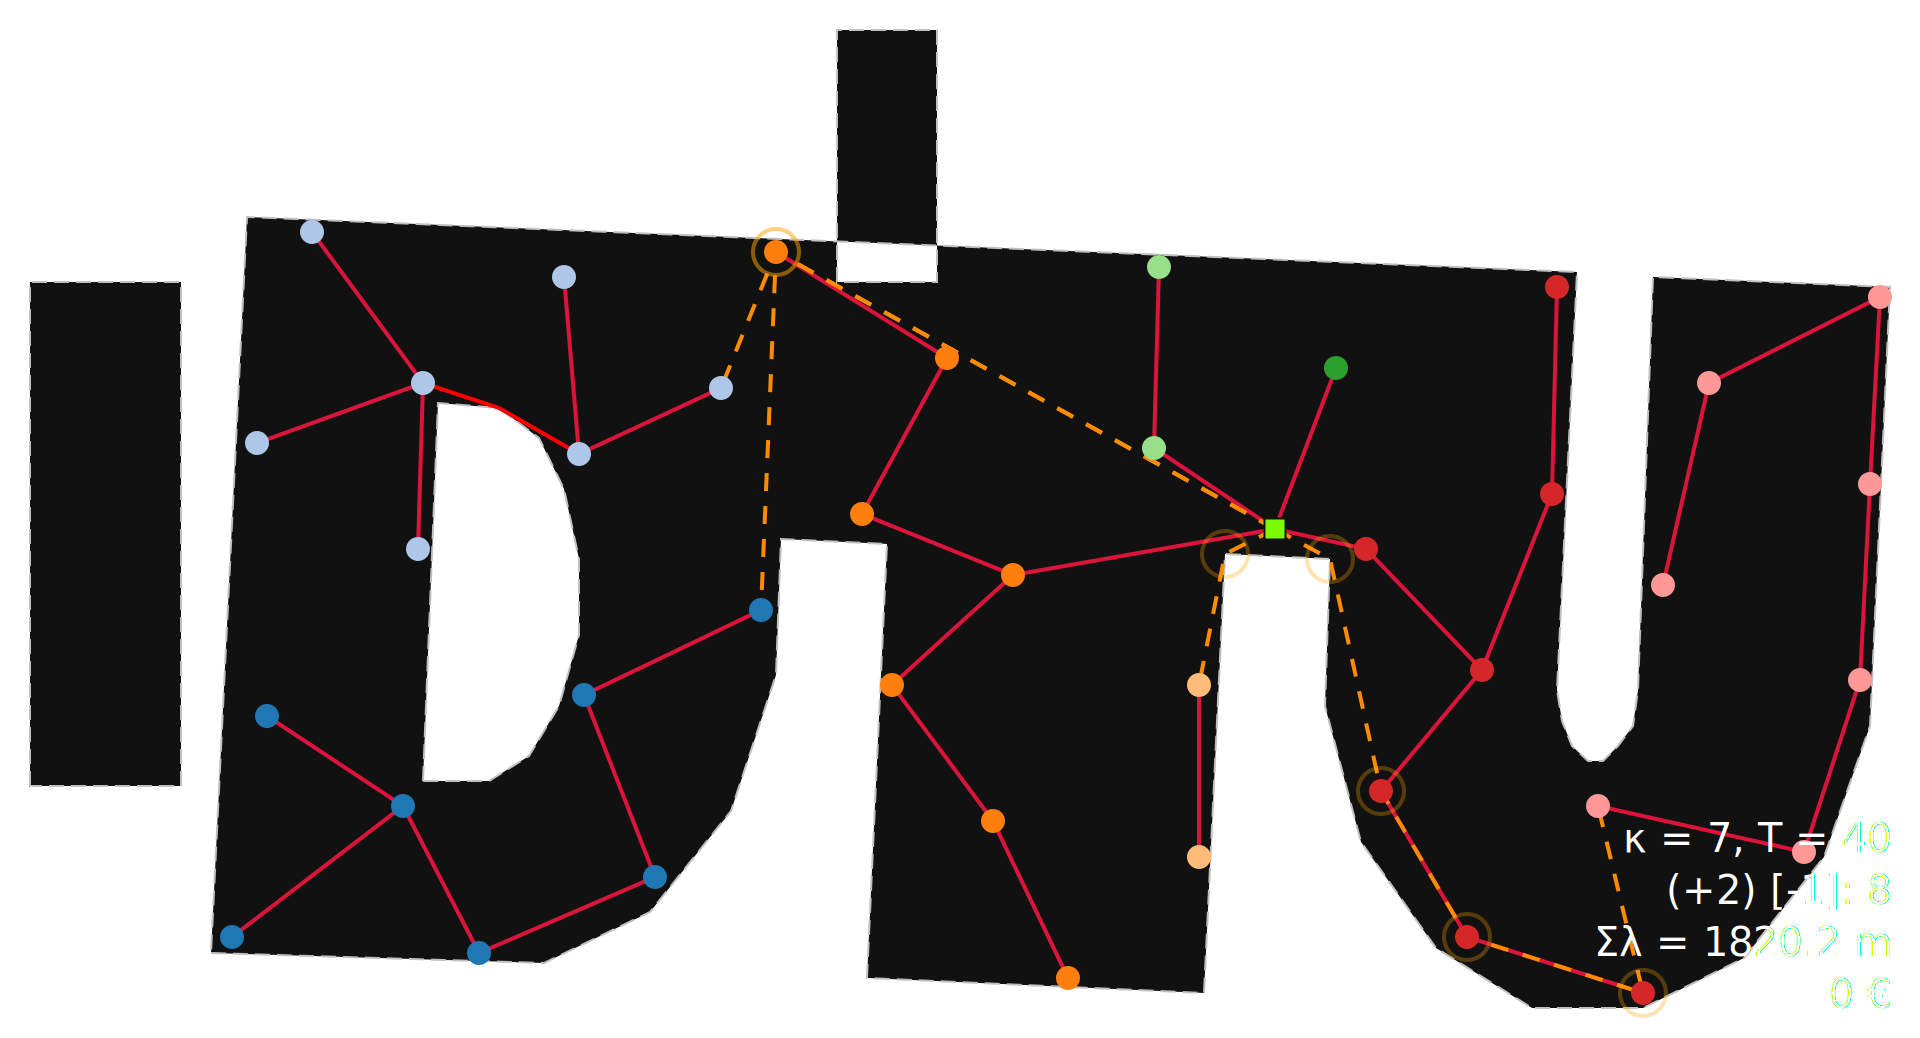

In [9]:
res_optimize = wfn2.optimize()
wfn2

We can use `.merge_obstacles_into_border()` to refine the borders, simplify the boundary constraints and remove unrelavant obstacles.

Obstacle at index 1 is completely outside the border and is neglected.
Obstacle at index 2 intersects with the exteriour border and is merged into the exterior border.


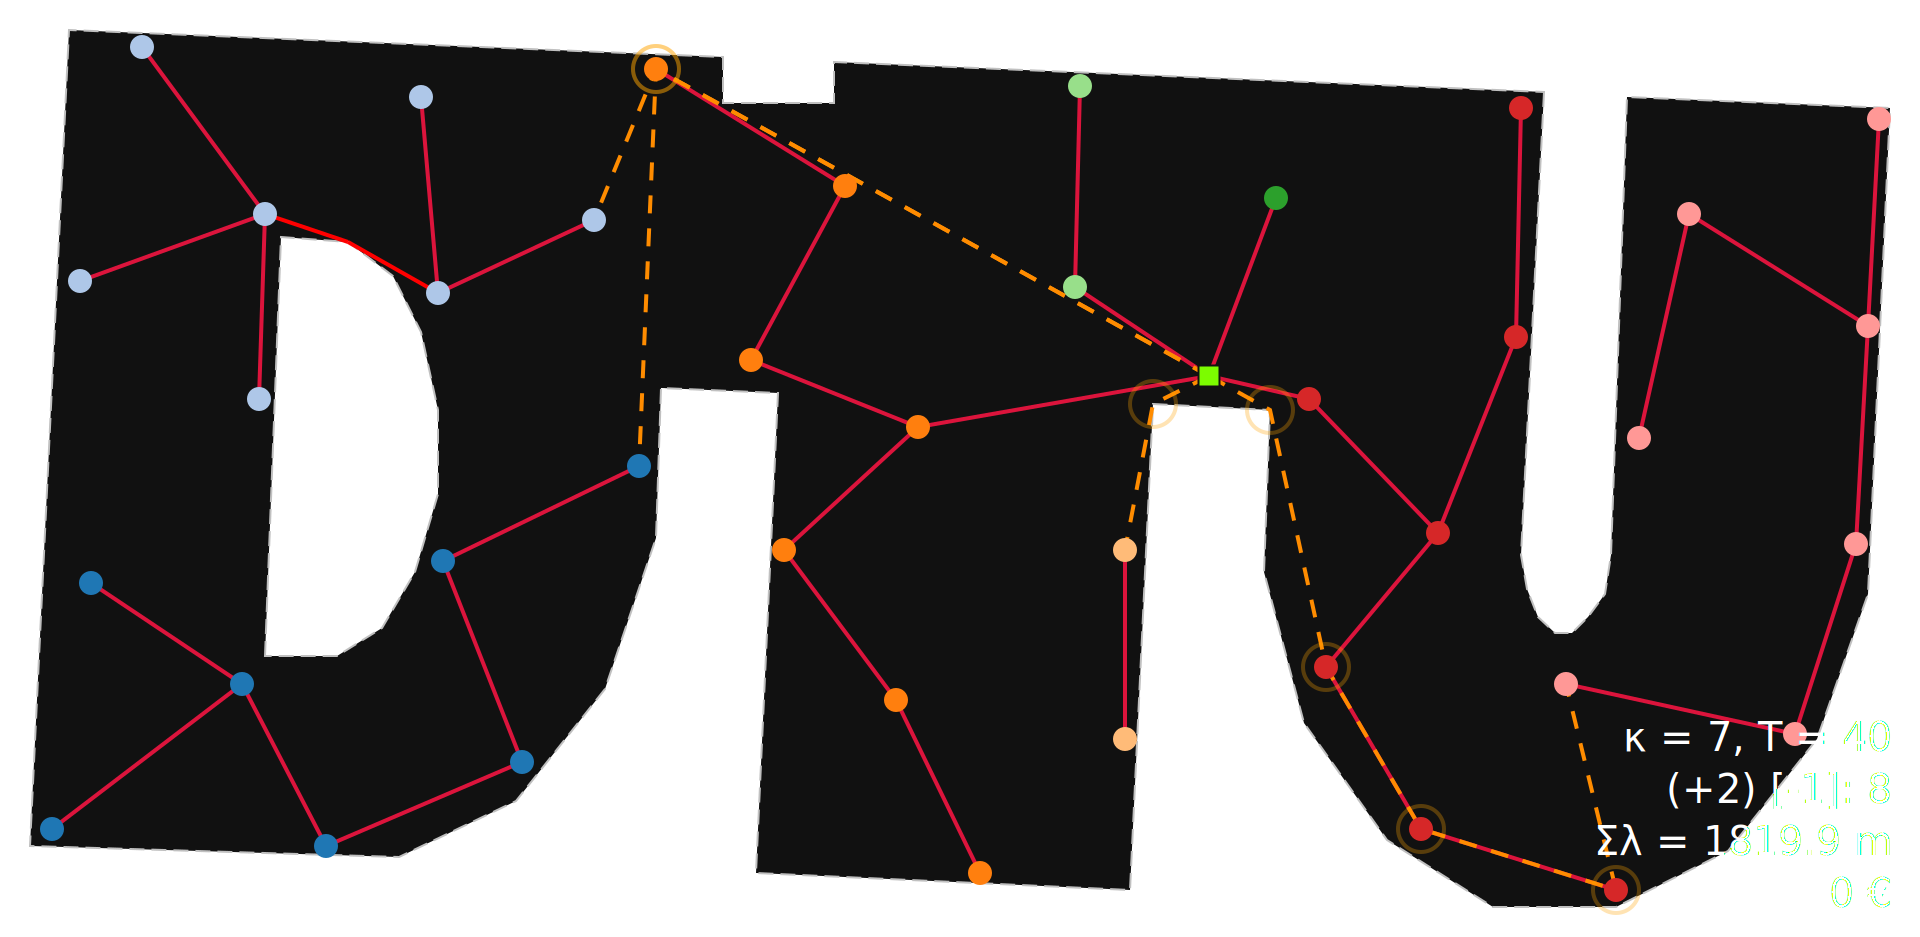

In [10]:
wfn2.merge_obstacles_into_border()
res_optimize = wfn2.optimize()
wfn2

## Buffering
After initializing the WindFarmNetwork, a buffer can be applied to borders and obstacles via `.buffer_border_obstacles` method. The exterior border will be expanded, while interior obstacles will be shrunk accordingly.

Initialize `WindFarmNetwork` instance

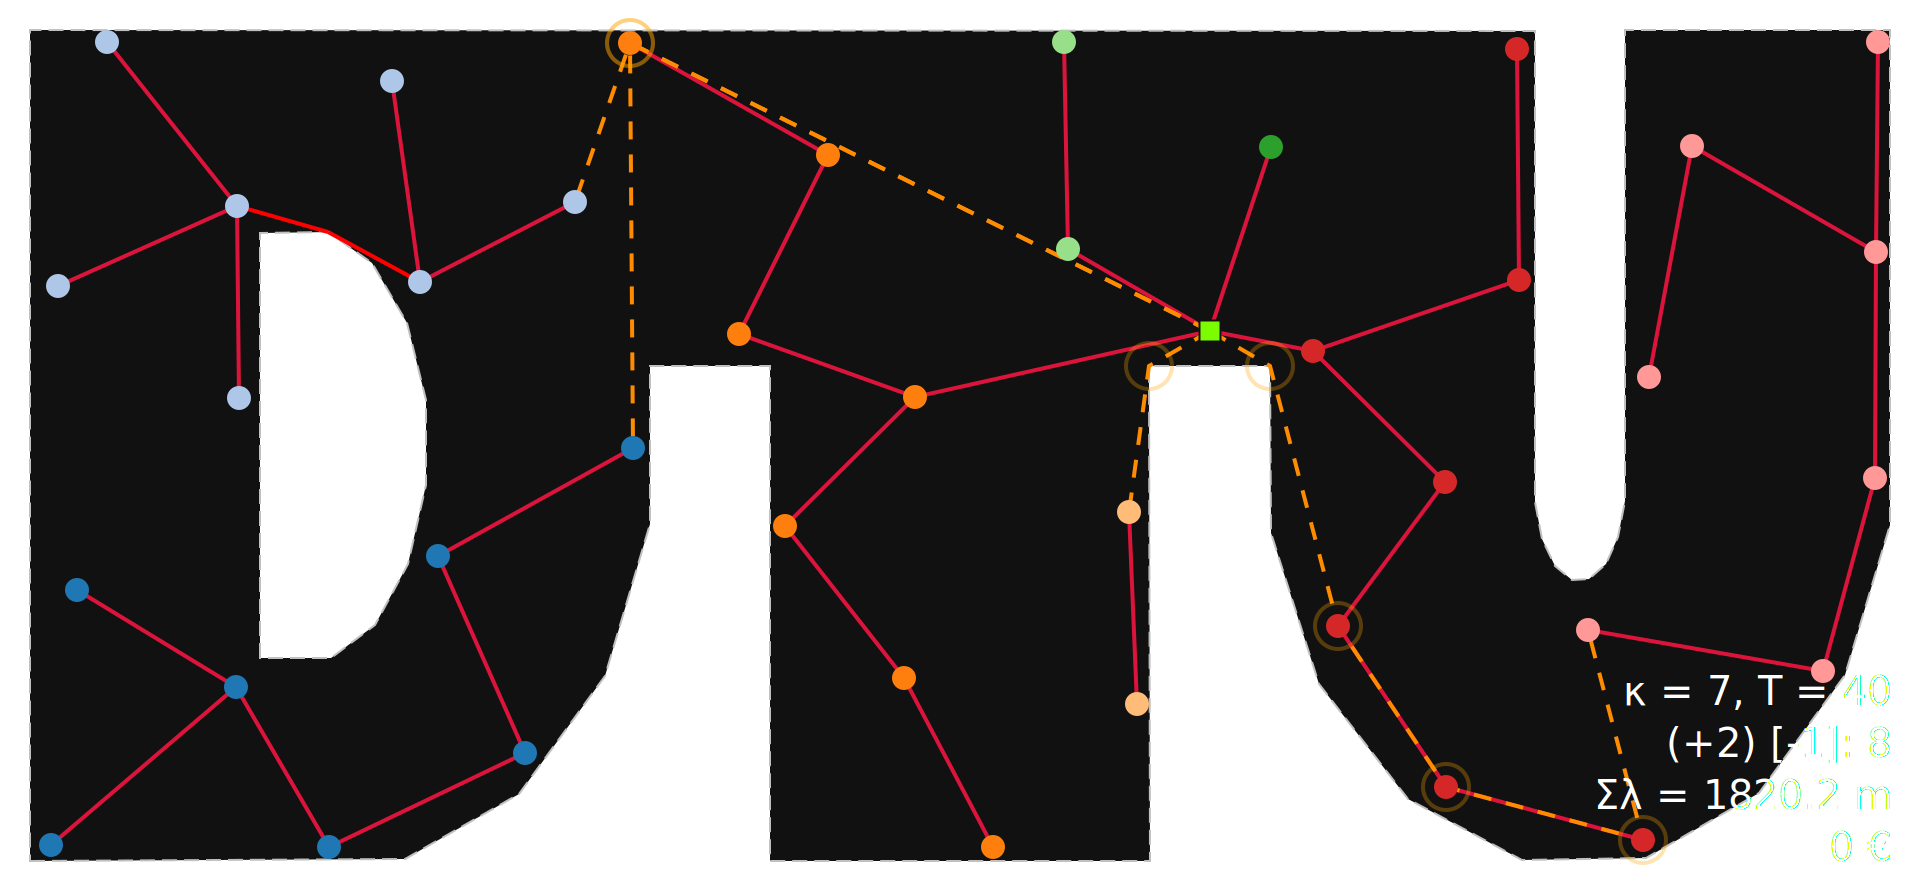

In [11]:
wfn3 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
res_optimize = wfn3.optimize()
wfn3

apply buffering to `wfn3`.

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().


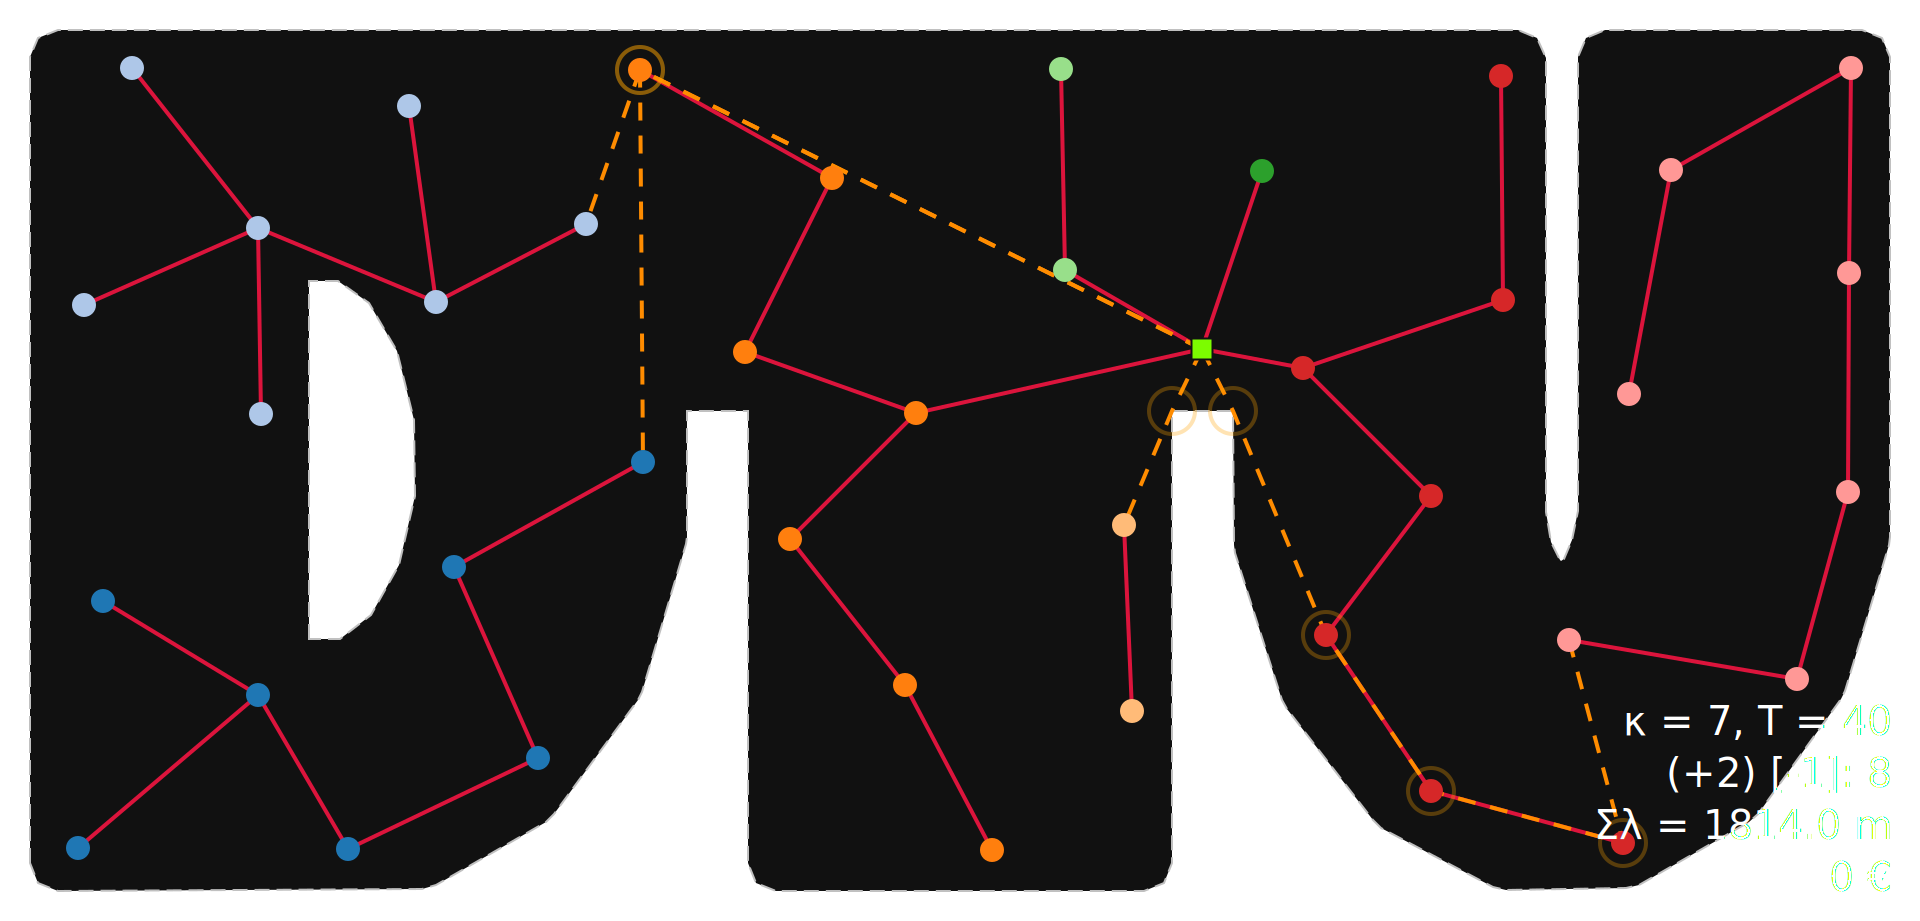

In [12]:
wfn3.add_buffer(buffer_dist=5)
res_optimize = wfn3.optimize()
wfn3

Original vs buffered border/obstacles can be visualized using plot_original_vs_buffered()

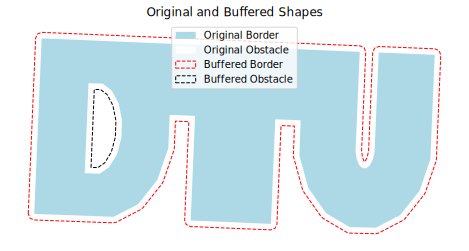

In [13]:
wfn3.plot_original_vs_buffered()

### Removal of a concavity
In this case a message is printed out, providing information about the potential changes in the border.

In [14]:
wfn4 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
wfn4.add_buffer(buffer_dist=10)

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().


Plotting original vs buffered borders confirms that one of the concavities is removed after buffering.

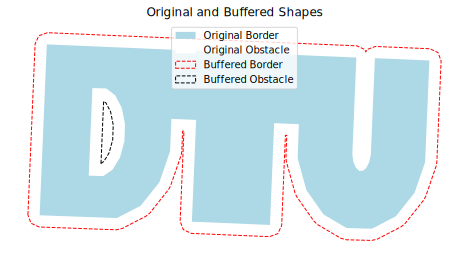

In [15]:
wfn4.plot_original_vs_buffered()

**Optimize**

The optimized network might change and use new routes after buffering.

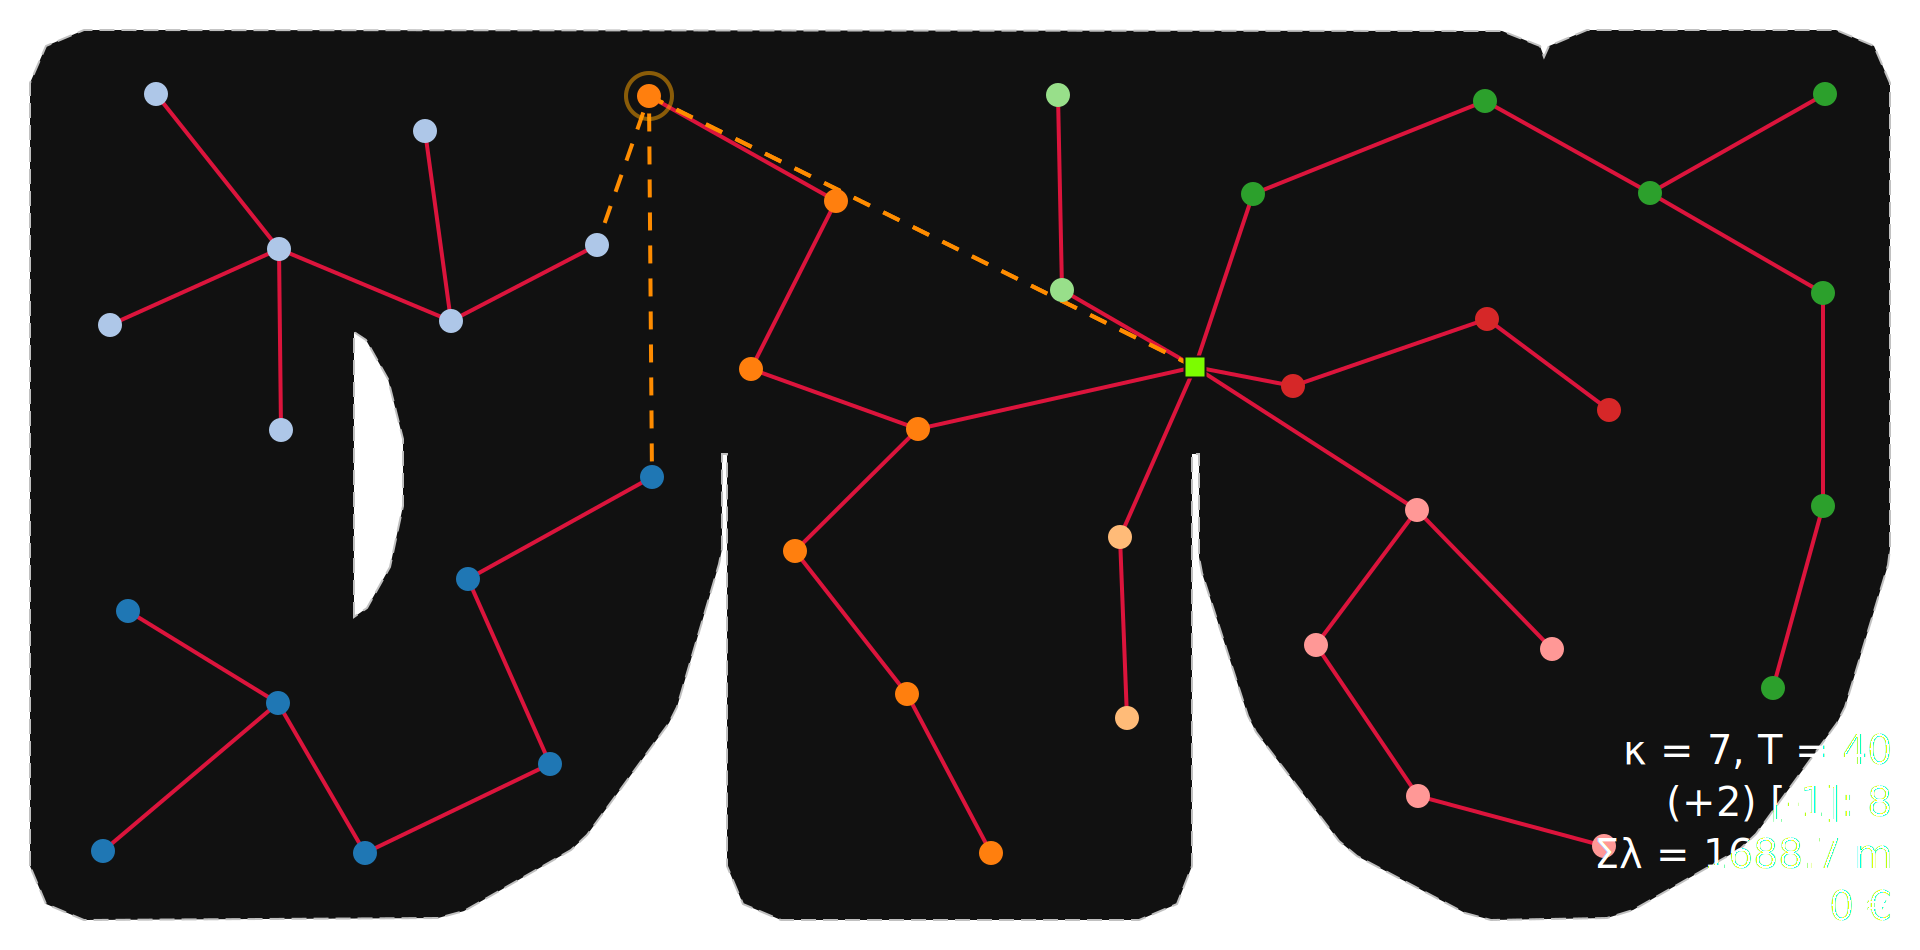

In [16]:
res_optimize = wfn4.optimize()
wfn4

### Removal of an obstacle

In [17]:
wfn5 = WindFarmNetwork.from_pbf(filepath='data/DTU_letters.osm.pbf', cables=7)
wfn5.add_buffer(buffer_dist=15)

The defined border is non-convex and buffering may introduce unexpected changes. For visual comparison use plot_original_vs_buffered().


Buffering by 15.00 completely removed the obstacle at index 0. For visual comparison use plot_original_vs_buffered().


Plotting original vs buffered borders confirms that abostacle (inside D letter) is removed after buffering.

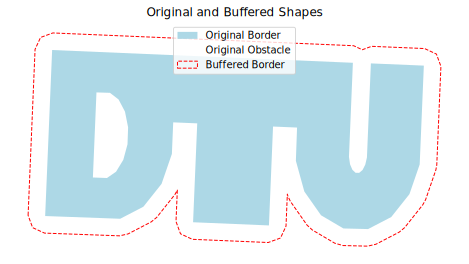

In [18]:
wfn5.plot_original_vs_buffered()

**Optimize**

The optimized network might change and use new routes after buffering.

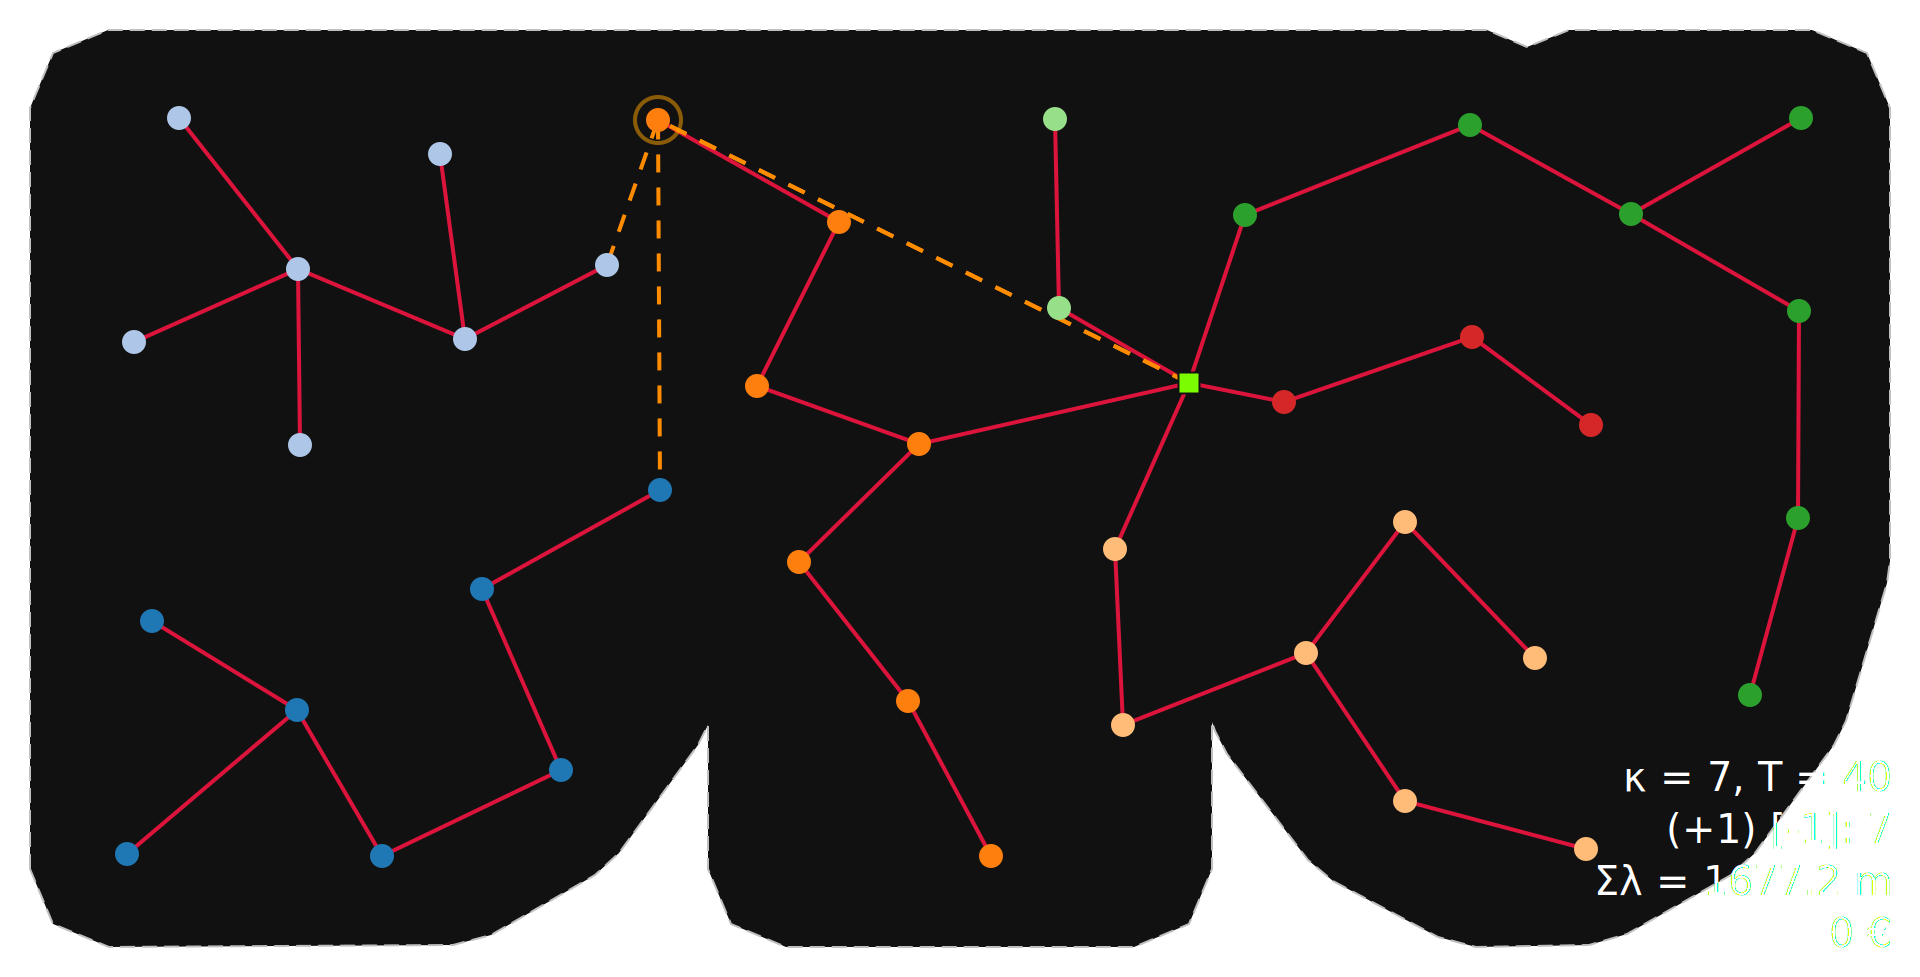

In [19]:
wfn5.optimize()
wfn5

### Turbines outside the border or inside the obstacles

`OptiWindNet` provide a method `.is_layout_within_bounds` to checks if the turbinesC/substationsC are defined properly with respect to the given border and obstacles.

In [20]:
turbinesC = np.array([
       [0, 0],
       [ 316976, 6175410],
       [ 316998, 6175380],
       ])

borderC = np.array([
       [316956, 6175267],
       [317022, 6175265],
       [317043, 6175275],
       [317059 , 6175295],
       [317068, 6175322],
       [317069, 6175349],
       [317090, 6175348],
       [317086, 6175262],
       [317153, 6175259],
       [317157, 6175346],
       [317178 , 6175345],
       [317177, 6175316],
       [317184, 6175289],
       [317199, 6175268],
       [317218, 6175256],
       [317240, 6175256],
       [317260, 6175266],
       [317276, 6175286],
       [317285, 6175312],
       [317289, 6175399],
       [317242, 6175401],
       [317239, 6175319],
       [317238, 6175312],
       [317235, 6175308],
       [317232, 6175305],
       [317229, 6175305],
       [317226, 6175308],
       [317224, 6175313],
       [317223, 6175319],
       [317227, 6175402],
       [316963, 6175413],
       ])

substationsC = np.array([
       [317167 , 6175351]])

In [25]:
wfn6 = WindFarmNetwork(turbinesC=turbinesC, substationsC=substationsC, borderC=borderC, obstacleC_=obstaclesC_, cables=7)
wfn6.optimize()

ValueError: Turbine out of bounds!